<a href="https://colab.research.google.com/github/BonanYang/Curriculum-Industry-Alignment/blob/main/Curriculum_Industry_Alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import shutil
from itertools import combinations
from google.colab import drive
import pandas as pd
import numpy as np
from numpy.linalg import norm
from sentence_transformers import SentenceTransformer
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
# model = SentenceTransformer('all-MiniLM-L6-v2')
# model = SentenceTransformer('all-mpnet-base-v2')
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2') #bad
# model = SentenceTransformer('BAAI/bge-base-en-v1.5')#Good
model = SentenceTransformer('BAAI/bge-large-en-v1.5')
# model = SentenceTransformer('intfloat/e5-large-v2')
# model = SentenceTransformer('Salesforce/SFR-Embedding-Mistral')
# model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1')#bad

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [2]:
!pip install pymupdf -q
import fitz  # PyMuPDF
import os
def cosine_sim(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

def extract_pdf_text(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text
coursemb = {}
syllabus_dir = 'ori/'

for filename in os.listdir(syllabus_dir):
    if filename.endswith('.pdf'):
        cid = filename.replace('.pdf', '')
        text = extract_pdf_text(os.path.join(syllabus_dir, filename))
        coursemb[cid] = model.encode(text[:10000])
        print(f"{cid}: {len(text)} chars")

print(f"Course embeddings: {len(coursemb)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 84.0 MB/s eta 0:00:00
224: 1088 chars
447: 2304 chars
490CN: 1667 chars
234: 912 chars
438: 537 chars
330: 1545 chars
240: 967 chars
286: 1637 chars
434: 886 chars
490DIP: 2806 chars
314: 1313 chars
150: 953 chars
490DL: 1163 chars
340: 2339 chars
476: 2141 chars
140: 921 chars
325: 3471 chars
490CV: 1085 chars
490ML: 701 chars
111: 1745 chars
321: 1306 chars
Course embeddings: 21


In [3]:
cs_skills = pd.read_csv('cs_skills_clean_1.csv')['id'].tolist()
skillemb = {}
for s in cs_skills:
    skillemb[s] = model.encode(s)
print(f"Skill embeddings: {len(skillemb)}")

Skill embeddings: 223


In [4]:
nodes_course = pd.DataFrame({
    'id': list(coursemb.keys()),
    'name': ['CS' + cid if not cid.startswith('CS') else cid for cid in coursemb.keys()]
})
nodes_course.to_csv('nodes_course.csv', index=False)
print(f"nodes_course: {len(nodes_course)}")
print(nodes_course)

nodes_course: 21
        id      name
0      224     CS224
1      447     CS447
2    490CN   CS490CN
3      234     CS234
4      438     CS438
5      330     CS330
6      240     CS240
7      286     CS286
8      434     CS434
9   490DIP  CS490DIP
10     314     CS314
11     150     CS150
12   490DL   CS490DL
13     340     CS340
14     476     CS476
15     140     CS140
16     325     CS325
17   490CV   CS490CV
18   490ML   CS490ML
19     111     CS111
20     321     CS321


In [5]:
nodes_skill = pd.DataFrame({
    'id': cs_skills,
    'name': cs_skills
})
nodes_skill.to_csv('nodes_skill.csv', index=False)
print(f"nodes_skill: {len(nodes_skill)}")

nodes_skill: 223


In [6]:
df_skill_raw = pd.read_csv('skills-1.csv')

# 只保留 15-, 17-, 19- 前缀的职位
cs_jobs = df_skill_raw[df_skill_raw['O*NET-SOC Code'].str.startswith(('15-', '17-', '19-'))]['Title'].unique()

nodes_job = pd.DataFrame({
    'id': cs_jobs,
    'name': cs_jobs
})
nodes_job.to_csv('nodes_job.csv', index=False)
print(f"nodes_job: {len(nodes_job)}")

nodes_job: 151


In [7]:
skill_matches = []
for cid, c_emb in coursemb.items():
    sims = []
    for skill, s_emb in skillemb.items():
        sim = cosine_sim(c_emb, s_emb)
        sims.append((skill, sim))
    top = sorted(sims, key=lambda x: x[1], reverse=True)[:5]
    for skill, sim in top:
        skill_matches.append((cid, skill, sim))

edges_matches_skill = pd.DataFrame(skill_matches, columns=['course', 'skill', 'similarity'])
edges_matches_skill.to_csv('edges_matches_skill.csv', index=False)
print(f"edges_matches_skill: {len(edges_matches_skill)}")

edges_matches_skill: 105


In [8]:
# 只保留 cs_skills 和 cs_jobs 的边
edges_job = df_skill_raw[
    (df_skill_raw['Example'].isin(cs_skills)) &
    (df_skill_raw['Title'].isin(cs_jobs))
][['Example', 'Title']].drop_duplicates()

edges_job.columns = ['source', 'target']
edges_job.to_csv('edges_required_by.csv', index=False)
print(f"edges_required_by: {len(edges_job)}")

edges_required_by: 3236


In [9]:
df_topics = pd.read_csv('coursesum.csv', header=None)

topics_list = []
edges_list = []

for _, row in df_topics.iterrows():
    cid = str(row[0])
    for topic in row[1:]:
        if pd.notna(topic) and str(topic).strip():
            topic_name = str(topic).strip()
            topic_id = f"{cid}_{topic_name}"
            topics_list.append({'id': topic_id, 'name': topic_name, 'course': cid})
            edges_list.append({'source': cid, 'target': topic_id})

nodes_topic = pd.DataFrame(topics_list)
edges_has_topic = pd.DataFrame(edges_list)

nodes_topic.to_csv('nodes_topic.csv', index=False)
edges_has_topic.to_csv('edges_has_topic.csv', index=False)

print(f"nodes_topic: {len(nodes_topic)}")
print(f"edges_has_topic: {len(edges_has_topic)}")

nodes_topic: 283
edges_has_topic: 283


In [10]:
import pandas as pd
import networkx as nx


nodes_course = pd.read_csv('nodes_course.csv')
nodes_topic = pd.read_csv('nodes_topic.csv')
nodes_skill = pd.read_csv('nodes_skill.csv')
nodes_job = pd.read_csv('nodes_job.csv')
edges_has_topic = pd.read_csv('edges_has_topic.csv')
edges_matches_skill = pd.read_csv('edges_matches_skill.csv')
edges_required_by = pd.read_csv('edges_required_by.csv')

G = nx.DiGraph()

for _, row in nodes_course.iterrows():
    G.add_node(row['id'], type='course', name=row['name'])
for _, row in nodes_topic.iterrows():
    G.add_node(row['id'], type='topic', name=row['name'])
for _, row in nodes_skill.iterrows():
    G.add_node(row['id'], type='skill', name=row['name'])
for _, row in nodes_job.iterrows():
    G.add_node(row['id'], type='job', name=row['name'])

for _, row in edges_has_topic.iterrows():
    G.add_edge(row['source'], row['target'], rel='HAS_TOPIC')
for _, row in edges_matches_skill.iterrows():
    G.add_edge(row['course'], row['skill'], rel='MATCHES_SKILL', weight=row['similarity'])
for _, row in edges_required_by.iterrows():
    G.add_edge(row['source'], row['target'], rel='REQUIRED_BY')

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 677, Edges: 3623


In [11]:
courses = [n for n, d in G.nodes(data=True) if d['type'] == 'course']
jobs = [n for n, d in G.nodes(data=True) if d['type'] == 'job']

In [12]:
course_reach = {}
for c in courses:
    reachable_jobs = set()
    for skill in G.successors(c):
        if G[c][skill].get('rel') == 'MATCHES_SKILL':
            for job in G.successors(skill):
                if G[skill][job].get('rel') == 'REQUIRED_BY':
                    reachable_jobs.add(job)
    course_reach[c] = len(reachable_jobs)

sorted_reach = sorted(course_reach.items(), key=lambda x: x[1], reverse=True)
print("=== Course-Job Reachability ===")
for c, count in sorted_reach:
    print(f"  {c:<10} {count} jobs")

=== Course-Job Reachability ===
  330        106 jobs
  240        106 jobs
  434        104 jobs
  224        103 jobs
  150        103 jobs
  140        103 jobs
  490DIP     98 jobs
  111        89 jobs
  314        88 jobs
  490ML      73 jobs
  490CV      56 jobs
  234        52 jobs
  321        40 jobs
  490CN      28 jobs
  286        25 jobs
  447        23 jobs
  325        23 jobs
  340        22 jobs
  476        10 jobs
  438        8 jobs
  490DL      6 jobs


In [13]:
matched_skills = set(edges_matches_skill['skill'].unique())

job_coverage = {}
for job in jobs:
    required = set([n for n in G.predecessors(job) if G[n][job].get('rel') == 'REQUIRED_BY'])
    covered = required & matched_skills
    if len(required) > 0:
        job_coverage[job] = (len(covered), len(required), len(covered)/len(required))

sorted_jobs = sorted(job_coverage.items(), key=lambda x: x[1][2], reverse=True)
print("=== Job Coverage (Top 20) ===")
for job, (cov, req, rate) in sorted_jobs[:20]:
    print(f"  {job[:50]:<50} {cov}/{req} ({rate*100:.1f}%)")

print("\n=== Job Coverage (Bottom 20) ===")
for job, (cov, req, rate) in sorted_jobs[-20:]:
    print(f"  {job[:50]:<50} {cov}/{req} ({rate*100:.1f}%)")

=== Job Coverage (Top 20) ===
  Marine Engineers and Naval Architects              1/1 (100.0%)
  Energy Engineers, Except Wind and Solar            4/4 (100.0%)
  Automotive Engineering Technicians                 1/1 (100.0%)
  Non-Destructive Testing Specialists                2/2 (100.0%)
  Geological Technicians, Except Hydrologic Technici 1/1 (100.0%)
  Environmental Engineering Technologists and Techni 8/9 (88.9%)
  Chemical Engineers                                 7/8 (87.5%)
  Environmental Scientists and Specialists, Includin 5/6 (83.3%)
  Photonics Technicians                              4/5 (80.0%)
  Geographers                                        4/5 (80.0%)
  Hydrologists                                       7/9 (77.8%)
  Environmental Engineers                            3/4 (75.0%)
  Civil Engineering Technologists and Technicians    3/4 (75.0%)
  Mechanical Engineering Technologists and Technicia 3/4 (75.0%)
  Food Scientists and Technologists                  3/

In [14]:
df_skill = pd.read_csv('skills-1.csv')
cs15_jobs = df_skill[df_skill['O*NET-SOC Code'].str.startswith('15-')]['Title'].unique()

print(f"15- prefix jobs: {len(cs15_jobs)}")
print("\n=== 15- Job Coverage ===")
for job in cs15_jobs:
    if job in job_coverage:
        cov, req, rate = job_coverage[job]
        print(f"  {job:<50} {cov}/{req} ({rate*100:.1f}%)")

15- prefix jobs: 35

=== 15- Job Coverage ===
  Computer Systems Analysts                          18/107 (16.8%)
  Health Informatics Specialists                     4/12 (33.3%)
  Information Security Analysts                      12/87 (13.8%)
  Computer and Information Research Scientists       18/75 (24.0%)
  Computer Network Support Specialists               5/30 (16.7%)
  Computer User Support Specialists                  13/83 (15.7%)
  Computer Network Architects                        16/98 (16.3%)
  Telecommunications Engineering Specialists         4/17 (23.5%)
  Database Administrators                            14/99 (14.1%)
  Database Architects                                13/104 (12.5%)
  Data Warehousing Specialists                       10/56 (17.9%)
  Network and Computer Systems Administrators        13/87 (14.9%)
  Computer Programmers                               17/94 (18.1%)
  Software Developers                                21/135 (15.6%)
  Software Quali

  Computer and Information Research Scientists       20 courses
  Software Developers                                20 courses
  Computer Systems Analysts                          18 courses
  Software Quality Assurance Analysts and Testers    18 courses
  Computer Programmers                               17 courses
  Computer Systems Engineers/Architects              17 courses
  Computer User Support Specialists                  16 courses
  Computer Network Architects                        16 courses
  Database Administrators                            16 courses
  Database Architects                                16 courses
  Web Developers                                     16 courses
  Data Scientists                                    16 courses
  Business Intelligence Analysts                     16 courses
  Web and Digital Interface Designers                15 courses
  Information Technology Project Managers            15 courses
  Information Security Analysts         

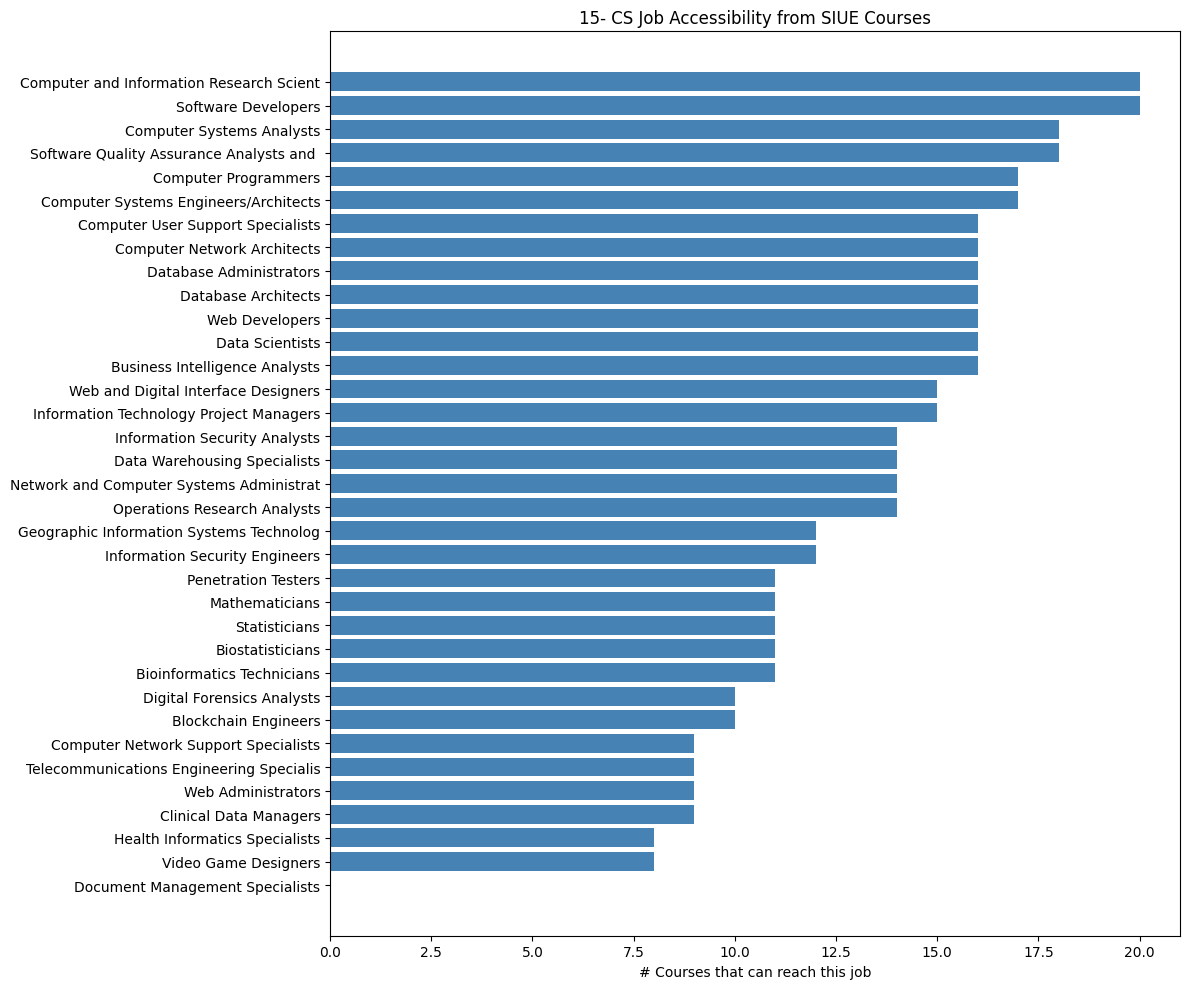

In [15]:

job_course_count = {}
for job in cs15_jobs:
    count = 0
    for c in courses:
        reachable = set()
        for skill in G.successors(c):
            if G[c][skill].get('rel') == 'MATCHES_SKILL':
                for j in G.successors(skill):
                    if G[skill][j].get('rel') == 'REQUIRED_BY':
                        reachable.add(j)
        if job in reachable:
            count += 1
    job_course_count[job] = count

sorted_jobs = sorted(job_course_count.items(), key=lambda x: x[1], reverse=True)

# print("=== 15- Job Reachability (# Courses) ===")
for job, count in sorted_jobs:
    print(f"  {job:<50} {count} courses")

# 柱状图
names, counts = zip(*sorted_jobs)
plt.figure(figsize=(12, 10))
plt.barh(range(len(names)), counts, color='steelblue')
plt.yticks(range(len(names)), [n[:40] for n in names])
plt.xlabel('# Courses that can reach this job')
plt.title('15- CS Job Accessibility from SIUE Courses')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('bar_15jobs_courses.png', dpi=150)
plt.show()

In [16]:
import seaborn as sns

# 获取 15- 职位
df_skill_raw = pd.read_csv('skills-1.csv')
cs15_jobs = df_skill_raw[df_skill_raw['O*NET-SOC Code'].str.startswith('15-')]['Title'].unique()

# 构建 Course x Job 矩阵
course_list = sorted(courses)
matrix = []

for c in course_list:
    row = []
    # 找该课程能到达的职位
    reachable = set()
    for skill in G.successors(c):
        if G[c][skill].get('rel') == 'MATCHES_SKILL':
            for job in G.successors(skill):
                if G[skill][job].get('rel') == 'REQUIRED_BY':
                    reachable.add(job)
    for job in cs15_jobs:
        row.append(1 if job in reachable else 0)
    matrix.append(row)

matrix = np.array(matrix)

# # 画图
# plt.figure(figsize=(14, 10))
# sns.heatmap(matrix, xticklabels=[j[:25] for j in cs15_jobs], yticklabels=course_list,
#             cmap='Blues', cbar=False)
# plt.xlabel('Job')
# plt.ylabel('Course')
# plt.title('Course-Job Reachability Heatmap (15- CS Jobs)')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.savefig('heatmap_course_15job.png', dpi=150)
# plt.show()

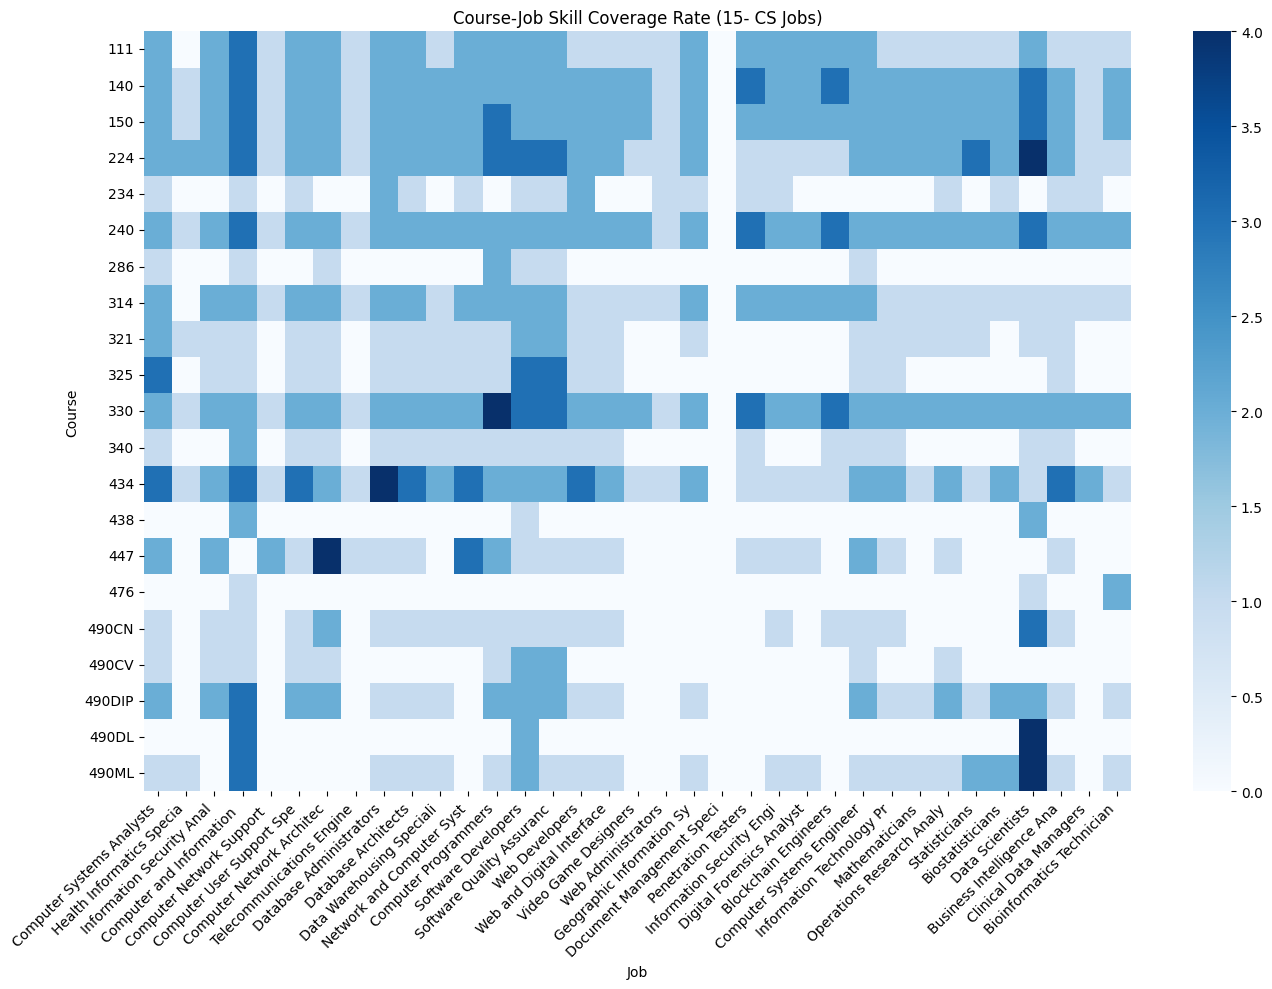

Max coverage: 400.0%
Mean coverage: 163.2%


In [17]:
# 构建 Course x Job 覆盖率矩阵
course_list = sorted(courses)
matched_skills = set(edges_matches_skill['skill'].unique())

matrix_coverage = []

for c in course_list:
    row = []
    # 找该课程匹配的技能
    course_skills = set()
    for skill in G.successors(c):
        if G[c][skill].get('rel') == 'MATCHES_SKILL':
            course_skills.add(skill)

    for job in cs15_jobs:
        # 该职位需要的所有技能
        job_skills = set([n for n in G.predecessors(job) if G.has_edge(n, job) and G[n][job].get('rel') == 'REQUIRED_BY'])
        if len(job_skills) > 0:
            # 课程覆盖的该职位技能
            covered = course_skills & job_skills
            # coverage = len(covered) / len(job_skills)
            coverage = len(covered)
        else:
            coverage = 0
        row.append(coverage)
    matrix_coverage.append(row)

matrix_coverage = np.array(matrix_coverage)

# 画图
plt.figure(figsize=(14, 10))
sns.heatmap(matrix_coverage, xticklabels=[j[:25] for j in cs15_jobs], yticklabels=course_list,
            cmap='Blues', cbar=True, vmin=0, vmax=matrix_coverage.max())
plt.xlabel('Job')
plt.ylabel('Course')
plt.title('Course-Job Skill Coverage Rate (15- CS Jobs)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('heatmap_course_job_coverage.png', dpi=150)
plt.show()

print(f"Max coverage: {matrix_coverage.max()*100:.1f}%")
print(f"Mean coverage: {matrix_coverage[matrix_coverage > 0].mean()*100:.1f}%")

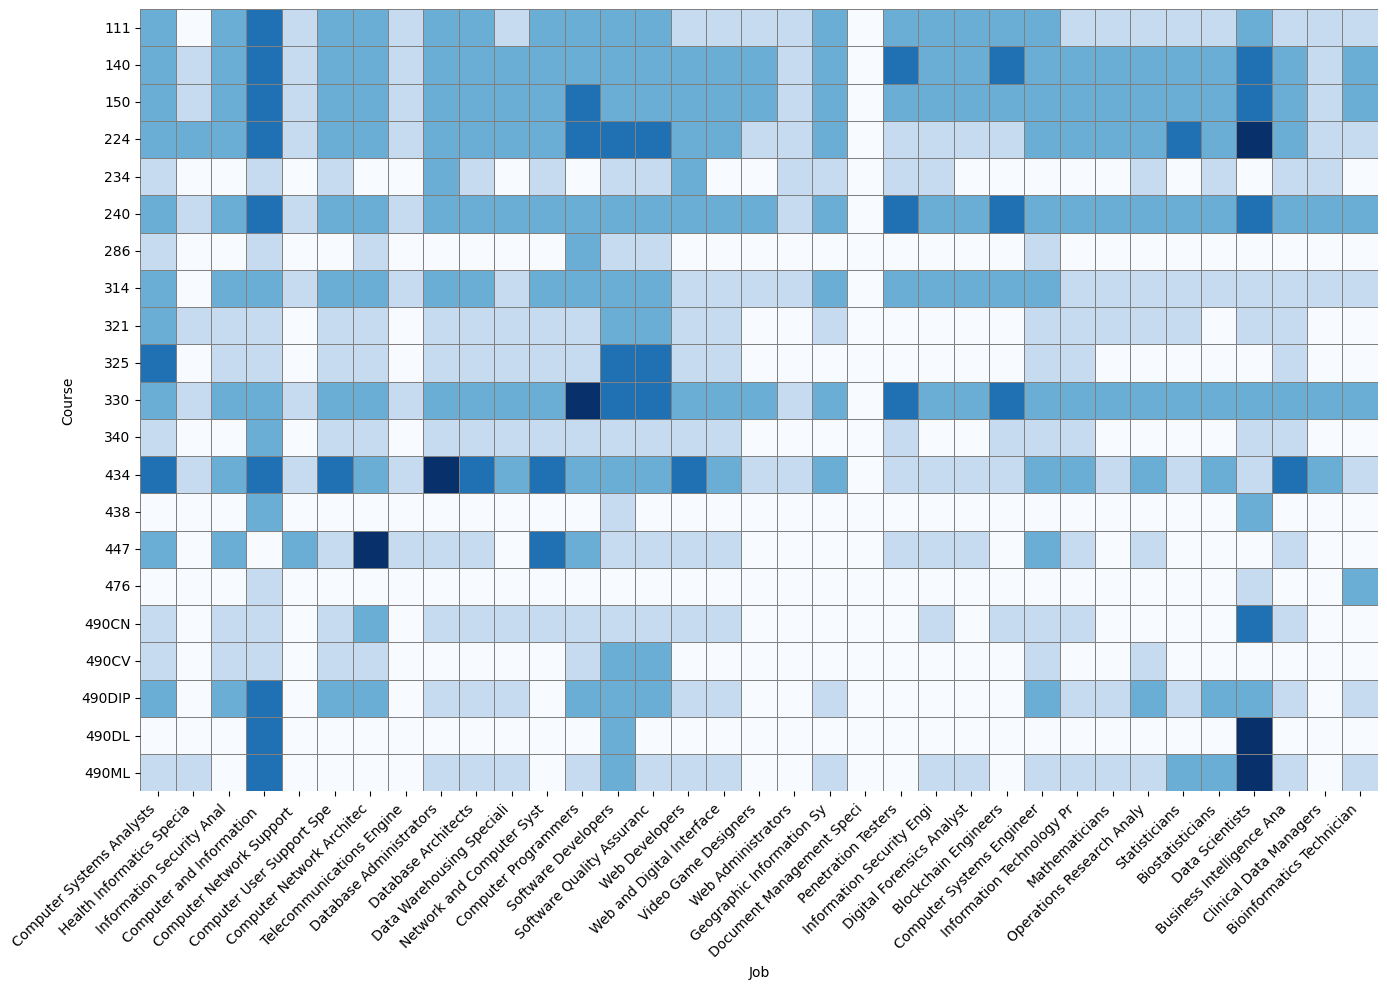

In [18]:
# 画图 - 加网格，调深颜色
plt.figure(figsize=(14, 10))
# sns.heatmap(matrix_coverage, xticklabels=[j[:25] for j in cs15_jobs], yticklabels=course_list,
#             cmap='Blues', cbar=True, vmin=0, vmax=matrix_coverage.max(),
#             linewidths=0.5, linecolor='gray')
sns.heatmap(matrix_coverage, xticklabels=[j[:25] for j in cs15_jobs], yticklabels=course_list,
            cmap='Blues', cbar=False, vmin=0, vmax=matrix_coverage.max(),
            linewidths=0.5, linecolor='gray')
plt.xlabel('Job')
plt.ylabel('Course')
# plt.title('Course-Job Skill Coverage Rate (15- CS Jobs)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('heatmap_course_job_coverage.png', dpi=300)
plt.show()

In [19]:
all_gaps = set()
for job in cs15_jobs:
    if job in job_coverage:
        required = set([n for n in G.predecessors(job) if G[n][job].get('rel') == 'REQUIRED_BY'])
        gap = required - matched_skills
        all_gaps.update(gap)

print(f"Total gap skills for 15- jobs: {len(all_gaps)}")


from collections import Counter
gap_count = []
for skill in all_gaps:
    count = 0
    for job in cs15_jobs:
        required = set([n for n in G.predecessors(job) if G[n][job].get('rel') == 'REQUIRED_BY'])
        if skill in required:
            count += 1
    gap_count.append((skill, count))

gap_count.sort(key=lambda x: x[1], reverse=True)



Total gap skills for 15- jobs: 162


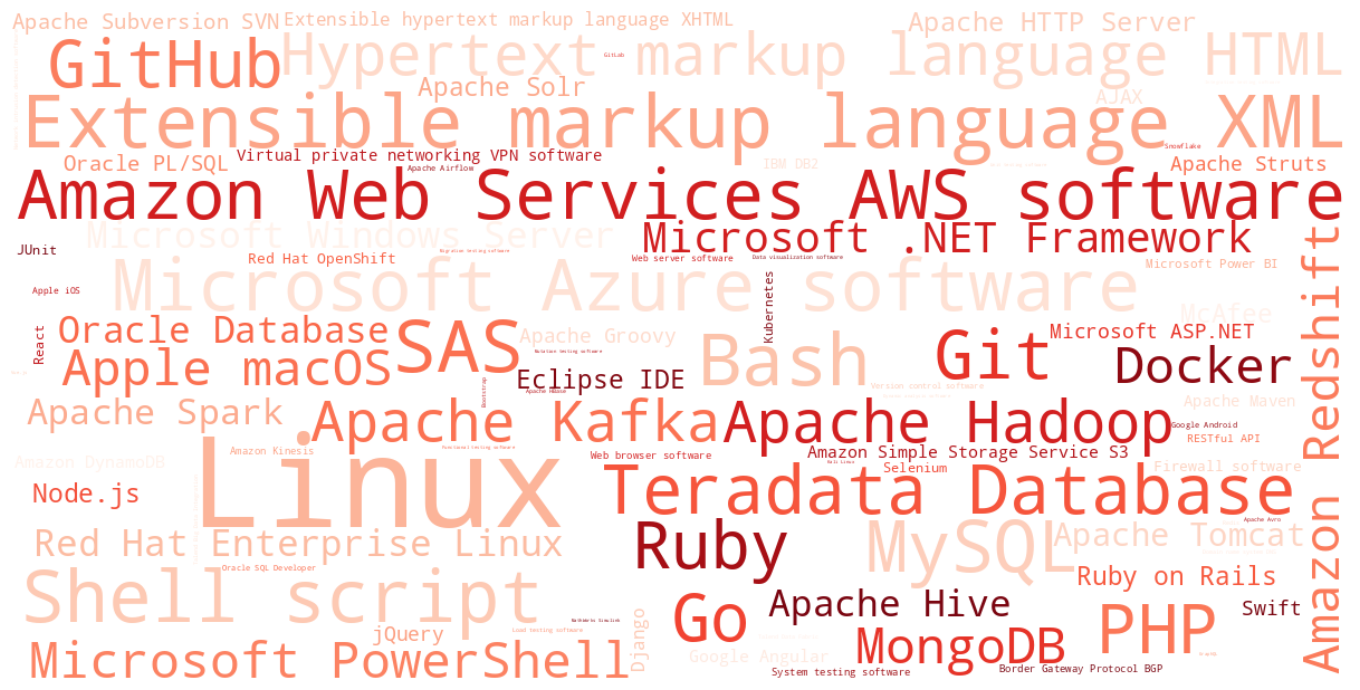

In [20]:
from wordcloud import WordCloud
gap_dict = {s: c for s, c in gap_count if c >= 3}
gap_dict = {s: c for s, c in gap_dict.items()
                     if 'Ubuntu' not in s and 'Visual Studio' not in s and 'Perl' not in s and 'Access' not in s and 'C' not in s and 'Java' not in s and 'SQL Server' not in s and 'UNIX' not in s}

wordcloud = WordCloud(width=1200, height=600, background_color='white',
                      colormap='Reds', max_words=100).generate_from_frequencies(gap_dict)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Skill Gaps in 15- CS Jobs (Size = # Jobs Requiring)', fontsize=14)
plt.tight_layout()
plt.savefig('wordcloud_gaps.png', dpi=300)
plt.show()

=== Well Covered Skills (Top 30) ===
  Structured query language SQL                      34 jobs
  Python                                             33 jobs
  C++                                                30 jobs
  R                                                  23 jobs
  The MathWorks MATLAB                               23 jobs
  Tableau                                            23 jobs
  Wireshark                                          21 jobs
  NoSQL                                              20 jobs
  Operating system software                          20 jobs
  Relational database management software            19 jobs
  Integrated development environment IDE software    17 jobs
  Quest Erwin Data Modeler                           16 jobs
  National Instruments LabVIEW                       10 jobs
  Verilog                                            7 jobs
  Database software                                  7 jobs
  Web application software                        

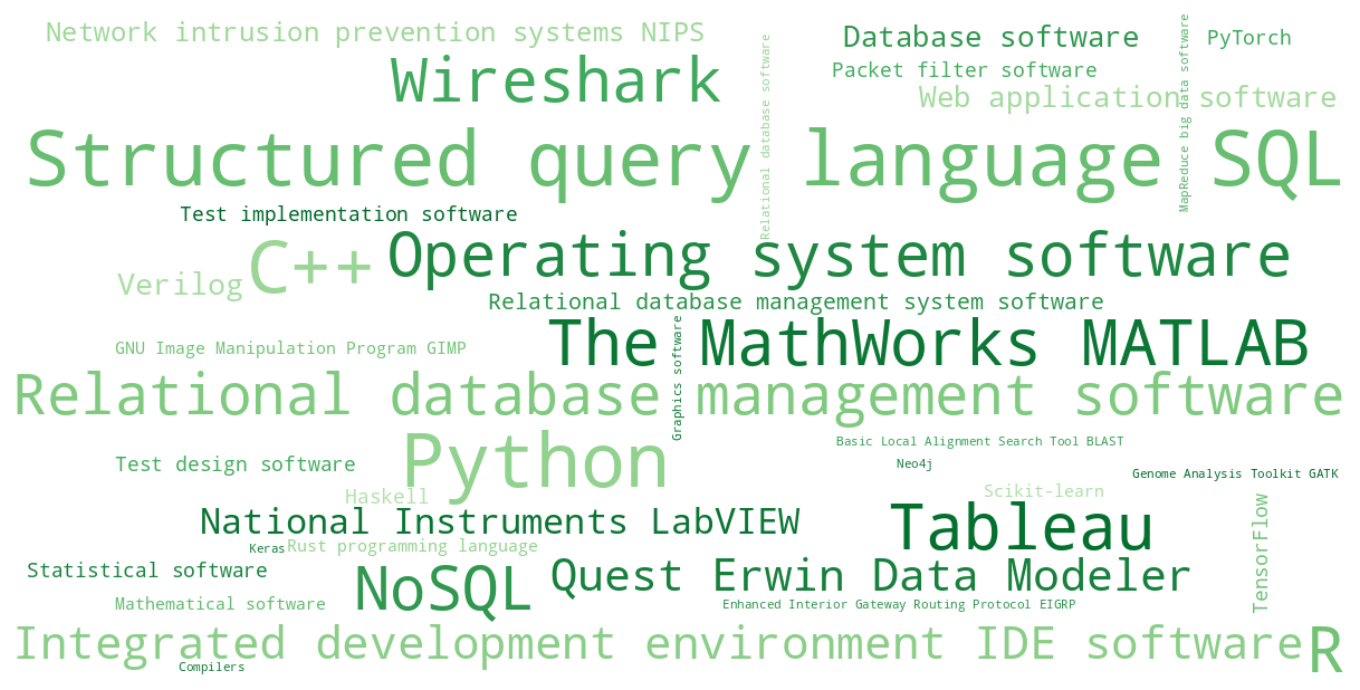

In [21]:
import numpy as np

covered_skills = set(edges_matches_skill['skill'].unique())
covered_count = []
for skill in covered_skills:
    count = 0
    for job in cs15_jobs:
        required = set([n for n in G.predecessors(job) if G.has_edge(n, job) and G[n][job].get('rel') == 'REQUIRED_BY'])
        if skill in required:
            count += 1
    if count > 0:
        covered_count.append((skill, count))

covered_count.sort(key=lambda x: x[1], reverse=True)

print("=== Well Covered Skills (Top 30) ===")
for skill, count in covered_count:
    print(f"  {skill:<50} {count} jobs")

# covered_dict = {s: c for s, c in covered_count if c >= 3}
covered_dict = {s: c for s, c in covered_count}
# wordcloud = WordCloud(width=1200, height=600, background_color='white',
#                       colormap='Greens', max_words=100,
#                       min_font_size=10, max_font_size=150).generate_from_frequencies(covered_dict)

# plt.figure(figsize=(14, 7))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Well Covered Skills by SIUE Curriculum (Size = # Jobs Requiring)', fontsize=14)
# plt.tight_layout()
# plt.savefig('wordcloud_covered.png', dpi=150)
# plt.show()

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 截取 Greens colormap 的深色部分 (0.3-0.9)
greens = plt.cm.Greens
colors = greens(np.linspace(0.3, 0.9, 256))
dark_greens = mcolors.LinearSegmentedColormap.from_list('DarkGreens', colors)

wordcloud = WordCloud(width=1200, height=600, background_color='white',
                      colormap=dark_greens, max_words=100,
                      min_font_size=10, max_font_size=150).generate_from_frequencies(covered_dict)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Well Covered Skills by SIUE Curriculum (Size = # Jobs Requiring)', fontsize=14)
plt.tight_layout()
plt.savefig('wordcloud_covered.png', dpi=300)
plt.show()